In [ ]:
import sys
import os
import random
import torch
import numpy as np
import itertools
import pandas as pd
import csv
from tqdm import tqdm
from box import Box

# Ajustar path al proyecto
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

from scripts.dataset_loader import load_dataset
from scripts.medical_scripts.medical_training import Training
from scripts.medical_scripts.medical_evaluation import ModelEvaluator
from scripts.MIL_utils import MIL_collate_fn

def run_experiment(config: Box):
    # Fijar semillas
    seed = config.seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Crear directorio de salida
    out_dir = f"./models/{config.dataset_name.split('-')[0]}/{config.pooling_type}/seed{seed}"
    os.makedirs(out_dir, exist_ok=True)

    # Cargar datos
    train_ds, val_ds = load_dataset(config=config, mode="train_val")
    test_ds          = load_dataset(config=config, mode="test")
    train_loader = torch.utils.data.DataLoader(
        train_ds, batch_size=config.batch_size, shuffle=True, collate_fn=MIL_collate_fn
    )
    val_loader = torch.utils.data.DataLoader(
        val_ds, batch_size=config.batch_size, shuffle=False, collate_fn=MIL_collate_fn
    )
    test_loader = torch.utils.data.DataLoader(
        test_ds, batch_size=config.batch_size, shuffle=False, collate_fn=MIL_collate_fn
    )

    # Entrenamiento
    trainer = Training(
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=config.num_epochs,
        learning_rate=config.learning_rate,
        output_model_dir=out_dir,
        pooling_type=config.pooling_type,
        input_feature_dim=config.input_feature_dim,
        feature_dim=config.feature_dim,
        wandb=None
    )
    trainer.train()

    # Épocas entrenadas (ajusta si tu Training usa otro atributo)
    trained_epochs = getattr(trainer, "current_epoch", config.num_epochs)

    # Guardar modelo
    model_path = os.path.join(out_dir, "model.pth")
    torch.save(trainer.model.state_dict(), model_path)

    # Evaluación en train
    evaluator_train = ModelEvaluator(
        model_path=model_path,
        test_loader=train_loader,
        batch_size=config.batch_size,
        input_feature_dim=config.input_feature_dim,
        feature_dim=config.feature_dim,
        pooling_type=config.pooling_type,
        wandb=None
    )
    train_metrics, _ = evaluator_train.evaluate()
    print(f"Train AUC: {train_metrics.get('auc')}")

    # Evaluación en test
    evaluator_test = ModelEvaluator(
        model_path=model_path,
        test_loader=test_loader,
        batch_size=config.batch_size,
        input_feature_dim=config.input_feature_dim,
        feature_dim=config.feature_dim,
        pooling_type=config.pooling_type,
        wandb=None
    )
    test_metrics, _ = evaluator_test.evaluate()
    print(f"Test AUC: {test_metrics.get('auc')}")

    # Devolver métricas + épocas
    return {
        "trained_epochs": trained_epochs,
        **{f"train_{k}": v for k, v in train_metrics.items()},
        **{f"test_{k}":  v for k, v in test_metrics.items()}
    }


def run_all_experiments():
    csv_file = "PANDA_experiment_runs.csv"
    header = [
        "dataset", "pooling", "learning_rate", "feature_dim", "seed",
        "trained_epochs",
        # métricas de train
        "train_loss", "train_accuracy", "train_f1_score", "train_auc", "train_precision", "train_recall",
        # métricas de test
        "test_loss",  "test_accuracy",  "test_f1_score",  "test_auc",  "test_precision",  "test_recall"
    ]

    # Si existe un CSV previo, lo cargamos y construimos el set de combinaciones ya hechas
    if os.path.exists(csv_file):
        df_done = pd.read_csv(csv_file)
        print("Últimos experimentos ejecutados:")
        display(df_done.tail())
        done_set = set(zip(
            df_done.dataset, df_done.pooling,
            df_done.learning_rate, df_done.feature_dim, df_done.seed
        ))
    else:
        # Creamos CSV con cabecera
        with open(csv_file, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(header)
        done_set = set()
        print("No se encontró CSV previo. Empezando desde cero.")

    # Rejilla de hiperparámetros
    datasets       = ["panda-patches_512_preset-features_UNI"]
    pooling_types  = ["attention", "mean", "max"]
    learning_rates = [1e-3, 1e-4]
    feature_dims   = [64, 128]
    seeds          = list(range(5))

    for dataset, pooling, lr, feat_dim in tqdm(
        itertools.product(datasets, pooling_types, learning_rates, feature_dims),
        desc="Grid search PANDA"
    ):
        for seed in seeds:
            key = (dataset, pooling, lr, feat_dim, seed)
            if key in done_set:
                continue  # ya ejecutado

            # Parámetros dinámicos: para PANDA usamos 1024, para otros 512
            input_feat_dim = 1024 if "panda" in dataset else 512
            num_epochs     = 50   if "panda" in dataset else 15

            config = Box({
                "dataset_name":      dataset,
                "input_feature_dim": input_feat_dim,
                "feature_dim":       feat_dim,
                "pooling_type":      pooling,
                "num_epochs":        num_epochs,
                "learning_rate":     lr,
                "batch_size":        1,
                "val_prop":          0.2,
                "seed":              seed,
                "use_inst_distances": False,
                "adj_mat_mode":      "relative"
            })

            print(f"\n=== Ejecutando: {dataset}, {pooling}, lr={lr}, feat_dim={feat_dim}, seed={seed} ===")
            metrics = run_experiment(config)

            # Preparar la fila para CSV
            row = [
                dataset, pooling, lr, feat_dim, seed,
                metrics.get("trained_epochs", ""),
                # train
                metrics.get("train_loss", ""),
                metrics.get("train_accuracy", ""),
                metrics.get("train_f1_score", ""),
                metrics.get("train_auc", ""),
                metrics.get("train_precision", ""),
                metrics.get("train_recall", ""),
                # test
                metrics.get("test_loss", ""),
                metrics.get("test_accuracy", ""),
                metrics.get("test_f1_score", ""),
                metrics.get("test_auc", ""),
                metrics.get("test_precision", ""),
                metrics.get("test_recall", ""),
            ]

            # Guardado inmediato al CSV
            with open(csv_file, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow(row)

            done_set.add(key)

    print("\nTodos los experimentos quedan registrados en", csv_file)


if __name__ == "__main__":
    run_all_experiments()


/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Últimos experimentos ejecutados:


,dataset,pooling,learning_rate,feature_dim,seed,trained_epochs,train_loss,train_accuracy,train_f1_score,train_auc,train_precision,train_recall,test_loss,test_accuracy,test_f1_score,test_auc,test_precision,test_recall
49,panda-patches_512_preset-features_UNI,max,0.0010,128,4,50,NaN,0.952077,0.966234,0.989956,0.992815,0.941039,NaN,0.924192,0.945294,0.976172,0.988225,0.905937
50,panda-patches_512_preset-features_UNI,max,0.0001,64,0,50,NaN,0.967957,0.977606,0.993152,0.995962,0.959914,NaN,0.949833,0.964455,0.979054,0.988664,0.941403
51,panda-patches_512_preset-features_UNI,max,0.0001,64,1,50,NaN,0.986531,0.990698,0.997886,0.997044,0.984433,NaN,0.950390,0.964808,0.983516,0.990260,0.940632
52,panda-patches_512_preset-features_UNI,max,0.0001,64,2,50,NaN,0.982844,0.988103,0.996060,0.998609,0.977817,NaN,0.952620,0.966575,0.982690,0.986356,0.947571
53,panda-patches_512_preset-features_UNI,max,0.0001,64,3,50,NaN,0.988374,0.991975,0.999192,0.997834,0.986184,NaN,0.950948,0.965327,0.983177,0.987107,0.944487


Grid search PANDA: 0it [00:00, ?it/s]


=== Ejecutando: panda-patches_512_preset-features_UNI, max, lr=0.0001, feat_dim=64, seed=4 ===
panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 8822/8822 [01:05<00:00, 135.36it/s]


[WSIDataset] Skipped 5 bags
[WSIDataset] Found 8817 already processed bags
panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 1794/1794 [00:13<00:00, 134.65it/s]


[WSIDataset] Skipped 0 bags
[WSIDataset] Found 1794 already processed bags
Epoch 1/50
Train - Loss: 0.1973, Acc: 0.9178, AUC: 0.9693, F1: 0.9432
Val   - Loss: 0.1908, Acc: 0.9206, AUC: 0.9822, F1: 0.9474
Final model saved to ./models/panda/max/seed4/model_max.pth
Epoch 2/50
Train - Loss: 0.1272, Acc: 0.9497, AUC: 0.9871, F1: 0.9652
Val   - Loss: 0.1682, Acc: 0.9308, AUC: 0.9835, F1: 0.9535
Final model saved to ./models/panda/max/seed4/model_max.pth
Epoch 3/50
Train - Loss: 0.1066, Acc: 0.9570, AUC: 0.9908, F1: 0.9704
Val   - Loss: 0.1528, Acc: 0.9427, AUC: 0.9827, F1: 0.9610
Epoch 4/50
Train - Loss: 0.0955, Acc: 0.9607, AUC: 0.9925, F1: 0.9729
Val   - Loss: 0.1711, Acc: 0.9308, AUC: 0.9840, F1: 0.9535
Final model saved to ./models/panda/max/seed4/model_max.pth
Epoch 5/50
Train - Loss: 0.0831, Acc: 0.9705, AUC: 0.9939, F1: 0.9797
Val   - Loss: 0.1691, Acc: 0.9314, AUC: 0.9857, F1: 0.9541
Final model saved to ./models/panda/max/seed4/model_max.pth
Epoch 6/50
Train - Loss: 0.0739, Acc: 0.

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.8929
Accuracy: 0.9892, AUC: 0.9992
Precision: 0.9951, Recall: 0.9901, F1-Score: 0.9926
Confusion Matrix:
[[1889   25]
 [  51 5088]]
Train AUC: 0.9992493426728586
Model loaded successfully from ./models/panda/max/seed4/model.pth


/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])
Grid search PANDA: 11it [20:11, 110.13s/it]

Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.9455
Accuracy: 0.9431, AUC: 0.9815
Precision: 0.9854, Recall: 0.9352, F1-Score: 0.9597
Confusion Matrix:
[[ 479   18]
 [  84 1213]]
Test AUC: 0.9814880028048011

=== Ejecutando: panda-patches_512_preset-features_UNI, max, lr=0.0001, feat_dim=128, seed=0 ===
panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 8822/8822 [01:12<00:00, 122.18it/s]


[WSIDataset] Skipped 5 bags
[WSIDataset] Found 8817 already processed bags
panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 1794/1794 [00:13<00:00, 133.01it/s]


[WSIDataset] Skipped 0 bags
[WSIDataset] Found 1794 already processed bags
Epoch 1/50
Train - Loss: 0.1952, Acc: 0.9213, AUC: 0.9706, F1: 0.9457
Val   - Loss: 0.1835, Acc: 0.9314, AUC: 0.9837, F1: 0.9510
Final model saved to ./models/panda/max/seed0/model_max.pth
Epoch 2/50
Train - Loss: 0.1302, Acc: 0.9497, AUC: 0.9860, F1: 0.9652
Val   - Loss: 0.1448, Acc: 0.9524, AUC: 0.9801, F1: 0.9667
Epoch 3/50
Train - Loss: 0.1145, Acc: 0.9568, AUC: 0.9891, F1: 0.9701
Val   - Loss: 0.1364, Acc: 0.9552, AUC: 0.9829, F1: 0.9688
Epoch 4/50
Train - Loss: 0.0955, Acc: 0.9653, AUC: 0.9926, F1: 0.9760
Val   - Loss: 0.1744, Acc: 0.9450, AUC: 0.9763, F1: 0.9612
Epoch 5/50
Train - Loss: 0.0817, Acc: 0.9691, AUC: 0.9946, F1: 0.9787
Val   - Loss: 0.1654, Acc: 0.9450, AUC: 0.9811, F1: 0.9611
Epoch 6/50
Train - Loss: 0.0641, Acc: 0.9756, AUC: 0.9967, F1: 0.9832
Val   - Loss: 0.1589, Acc: 0.9512, AUC: 0.9808, F1: 0.9657
Early stopping triggered.
Model loaded successfully from ./models/panda/max/seed0/model.pth

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.3850
Accuracy: 0.9784, AUC: 0.9943
Precision: 0.9968, Recall: 0.9735, F1-Score: 0.9850
Confusion Matrix:
[[1898   16]
 [ 136 5003]]
Train AUC: 0.9942677169260901
Model loaded successfully from ./models/panda/max/seed0/model.pth


/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.5680
Accuracy: 0.9493, AUC: 0.9795
Precision: 0.9894, Recall: 0.9399, F1-Score: 0.9640
Confusion Matrix:
[[ 484   13]
 [  78 1219]]
Test AUC: 0.9794573144340214

=== Ejecutando: panda-patches_512_preset-features_UNI, max, lr=0.0001, feat_dim=128, seed=1 ===
panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 8822/8822 [01:13<00:00, 119.23it/s]


[WSIDataset] Skipped 5 bags
[WSIDataset] Found 8817 already processed bags
panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 1794/1794 [00:14<00:00, 124.22it/s]


[WSIDataset] Skipped 0 bags
[WSIDataset] Found 1794 already processed bags
Epoch 1/50
Train - Loss: 0.1813, Acc: 0.9253, AUC: 0.9742, F1: 0.9484
Val   - Loss: 0.1789, Acc: 0.9337, AUC: 0.9735, F1: 0.9545
Final model saved to ./models/panda/max/seed1/model_max.pth
Epoch 2/50
Train - Loss: 0.1229, Acc: 0.9555, AUC: 0.9876, F1: 0.9692
Val   - Loss: 0.1618, Acc: 0.9365, AUC: 0.9778, F1: 0.9555
Final model saved to ./models/panda/max/seed1/model_max.pth
Epoch 3/50
Train - Loss: 0.1043, Acc: 0.9594, AUC: 0.9908, F1: 0.9720
Val   - Loss: 0.1747, Acc: 0.9342, AUC: 0.9734, F1: 0.9540
Epoch 4/50
Train - Loss: 0.0884, Acc: 0.9663, AUC: 0.9936, F1: 0.9767
Val   - Loss: 0.1744, Acc: 0.9354, AUC: 0.9772, F1: 0.9545
Epoch 5/50
Train - Loss: 0.0729, Acc: 0.9736, AUC: 0.9956, F1: 0.9818
Val   - Loss: 0.1949, Acc: 0.9331, AUC: 0.9703, F1: 0.9533
Epoch 6/50
Train - Loss: 0.0623, Acc: 0.9772, AUC: 0.9968, F1: 0.9843
Val   - Loss: 0.1873, Acc: 0.9286, AUC: 0.9736, F1: 0.9514
Epoch 7/50
Train - Loss: 0.0523

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.7055
Accuracy: 0.9765, AUC: 0.9943
Precision: 0.9952, Recall: 0.9724, F1-Score: 0.9837
Confusion Matrix:
[[1890   24]
 [ 142 4997]]
Train AUC: 0.9943092986755043
Model loaded successfully from ./models/panda/max/seed1/model.pth


/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.8857
Accuracy: 0.9437, AUC: 0.9778
Precision: 0.9894, Recall: 0.9322, F1-Score: 0.9599
Confusion Matrix:
[[ 484   13]
 [  88 1209]]
Test AUC: 0.9778330740030001

=== Ejecutando: panda-patches_512_preset-features_UNI, max, lr=0.0001, feat_dim=128, seed=2 ===
panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 8822/8822 [01:12<00:00, 121.79it/s]


[WSIDataset] Skipped 5 bags
[WSIDataset] Found 8817 already processed bags
panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 1794/1794 [00:13<00:00, 128.17it/s]


[WSIDataset] Skipped 0 bags
[WSIDataset] Found 1794 already processed bags
Epoch 1/50
Train - Loss: 0.1900, Acc: 0.9195, AUC: 0.9720, F1: 0.9445
Val   - Loss: 0.1519, Acc: 0.9467, AUC: 0.9847, F1: 0.9625
Final model saved to ./models/panda/max/seed2/model_max.pth
Epoch 2/50
Train - Loss: 0.1304, Acc: 0.9485, AUC: 0.9861, F1: 0.9644
Val   - Loss: 0.1387, Acc: 0.9524, AUC: 0.9832, F1: 0.9667
Epoch 3/50
Train - Loss: 0.1095, Acc: 0.9565, AUC: 0.9901, F1: 0.9699
Val   - Loss: 0.1425, Acc: 0.9518, AUC: 0.9834, F1: 0.9663
Epoch 4/50
Train - Loss: 0.0936, Acc: 0.9623, AUC: 0.9931, F1: 0.9740
Val   - Loss: 0.1915, Acc: 0.9365, AUC: 0.9841, F1: 0.9548
Epoch 5/50
Train - Loss: 0.0766, Acc: 0.9685, AUC: 0.9952, F1: 0.9783
Val   - Loss: 0.1779, Acc: 0.9439, AUC: 0.9845, F1: 0.9603
Epoch 6/50
Train - Loss: 0.0645, Acc: 0.9752, AUC: 0.9966, F1: 0.9829
Val   - Loss: 0.2090, Acc: 0.9382, AUC: 0.9833, F1: 0.9560
Early stopping triggered.
Model loaded successfully from ./models/panda/max/seed2/model.pth

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.1140
Accuracy: 0.9786, AUC: 0.9943
Precision: 0.9964, Recall: 0.9741, F1-Score: 0.9851
Confusion Matrix:
[[1896   18]
 [ 133 5006]]
Train AUC: 0.9942551102343359
Model loaded successfully from ./models/panda/max/seed2/model.pth


/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.3182
Accuracy: 0.9504, AUC: 0.9818
Precision: 0.9919, Recall: 0.9391, F1-Score: 0.9648
Confusion Matrix:
[[ 487   10]
 [  79 1218]]
Test AUC: 0.9818432569200863

=== Ejecutando: panda-patches_512_preset-features_UNI, max, lr=0.0001, feat_dim=128, seed=3 ===
panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 8822/8822 [01:12<00:00, 121.59it/s]


[WSIDataset] Skipped 5 bags
[WSIDataset] Found 8817 already processed bags
panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 1794/1794 [00:14<00:00, 128.07it/s]


[WSIDataset] Skipped 0 bags
[WSIDataset] Found 1794 already processed bags
Epoch 1/50
Train - Loss: 0.1871, Acc: 0.9219, AUC: 0.9724, F1: 0.9462
Val   - Loss: 0.1661, Acc: 0.9399, AUC: 0.9857, F1: 0.9595
Final model saved to ./models/panda/max/seed3/model_max.pth
Epoch 2/50
Train - Loss: 0.1291, Acc: 0.9477, AUC: 0.9864, F1: 0.9638
Val   - Loss: 0.1424, Acc: 0.9495, AUC: 0.9874, F1: 0.9657
Final model saved to ./models/panda/max/seed3/model_max.pth
Epoch 3/50
Train - Loss: 0.1085, Acc: 0.9589, AUC: 0.9903, F1: 0.9716
Val   - Loss: 0.1318, Acc: 0.9439, AUC: 0.9878, F1: 0.9608
Final model saved to ./models/panda/max/seed3/model_max.pth
Epoch 4/50
Train - Loss: 0.0935, Acc: 0.9648, AUC: 0.9928, F1: 0.9757
Val   - Loss: 0.1349, Acc: 0.9473, AUC: 0.9851, F1: 0.9634
Epoch 5/50
Train - Loss: 0.0794, Acc: 0.9716, AUC: 0.9946, F1: 0.9804
Val   - Loss: 0.1614, Acc: 0.9478, AUC: 0.9786, F1: 0.9635
Epoch 6/50
Train - Loss: 0.0631, Acc: 0.9756, AUC: 0.9968, F1: 0.9832
Val   - Loss: 0.1522, Acc: 0.9

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.0657
Accuracy: 0.9938, AUC: 0.9997
Precision: 0.9998, Recall: 0.9916, F1-Score: 0.9957
Confusion Matrix:
[[1913    1]
 [  43 5096]]
Train AUC: 0.9996714126794445
Model loaded successfully from ./models/panda/max/seed3/model.pth


/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.4878
Accuracy: 0.9515, AUC: 0.9842
Precision: 0.9895, Recall: 0.9429, F1-Score: 0.9657
Confusion Matrix:
[[ 484   13]
 [  74 1223]]
Test AUC: 0.9841593896455061

=== Ejecutando: panda-patches_512_preset-features_UNI, max, lr=0.0001, feat_dim=128, seed=4 ===
panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 8822/8822 [01:08<00:00, 128.81it/s]


[WSIDataset] Skipped 5 bags
[WSIDataset] Found 8817 already processed bags
panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 1794/1794 [00:13<00:00, 129.05it/s]


[WSIDataset] Skipped 0 bags
[WSIDataset] Found 1794 already processed bags
Epoch 1/50
Train - Loss: 0.1884, Acc: 0.9207, AUC: 0.9723, F1: 0.9453
Val   - Loss: 0.1675, Acc: 0.9450, AUC: 0.9815, F1: 0.9612
Final model saved to ./models/panda/max/seed4/model_max.pth
Epoch 2/50
Train - Loss: 0.1218, Acc: 0.9517, AUC: 0.9880, F1: 0.9665
Val   - Loss: 0.1511, Acc: 0.9484, AUC: 0.9811, F1: 0.9641
Epoch 3/50
Train - Loss: 0.1074, Acc: 0.9606, AUC: 0.9906, F1: 0.9728
Val   - Loss: 0.1471, Acc: 0.9490, AUC: 0.9821, F1: 0.9644
Final model saved to ./models/panda/max/seed4/model_max.pth
Epoch 4/50
Train - Loss: 0.0926, Acc: 0.9658, AUC: 0.9927, F1: 0.9764
Val   - Loss: 0.1513, Acc: 0.9478, AUC: 0.9805, F1: 0.9638
Epoch 5/50
Train - Loss: 0.0752, Acc: 0.9712, AUC: 0.9954, F1: 0.9802
Val   - Loss: 0.1563, Acc: 0.9461, AUC: 0.9834, F1: 0.9622
Final model saved to ./models/panda/max/seed4/model_max.pth
Epoch 6/50
Train - Loss: 0.0630, Acc: 0.9792, AUC: 0.9965, F1: 0.9856
Val   - Loss: 0.2103, Acc: 0.9

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.4866
Accuracy: 0.9823, AUC: 0.9957
Precision: 0.9974, Recall: 0.9782, F1-Score: 0.9877
Confusion Matrix:
[[1901   13]
 [ 112 5027]]
Train AUC: 0.9956520130141724
Model loaded successfully from ./models/panda/max/seed4/model.pth


/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])
Grid search PANDA: 12it [1:29:39, 448.29s/it]

Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.6844
Accuracy: 0.9476, AUC: 0.9750
Precision: 0.9831, Recall: 0.9437, F1-Score: 0.9630
Confusion Matrix:
[[ 476   21]
 [  73 1224]]
Test AUC: 0.9749600145204304

Todos los experimentos quedan registrados en PANDA_experiment_runs.csv


In [3]:
import pandas as pd
import numpy as np

# Cargar el CSV
df = pd.read_csv('PANDA_experiment_runs.csv')

# Definir las métricas para calcular estadísticas
metrics_to_analyze = [
    'train_accuracy', 'train_f1_score', 'train_auc', 'train_precision', 'train_recall',
    'test_accuracy', 'test_f1_score', 'test_auc', 'test_precision', 'test_recall'
]

# Agrupar por hiperparámetros (excluyendo seed)
groupby_cols = ['dataset', 'pooling', 'learning_rate', 'feature_dim']

# Calcular estadísticas agrupadas
results_summary = []

for group_name, group_data in df.groupby(groupby_cols):
    dataset, pooling, lr, feature_dim = group_name
    
    # Crear diccionario base para este grupo
    row = {
        'dataset': dataset,
        'pooling': pooling,
        'learning_rate': lr,
        'feature_dim': feature_dim,
        'n_seeds': len(group_data)
    }
    
    # Calcular medias y desviaciones para cada métrica
    for metric in metrics_to_analyze:
        if metric in group_data.columns:
            values = group_data[metric].dropna()
            if len(values) > 0:
                row[f'{metric}_mean'] = values.mean()
                row[f'{metric}_std'] = values.std() if len(values) > 1 else 0.0
    
    results_summary.append(row)

# Convertir a DataFrame
df_clean = pd.DataFrame(results_summary)

# Guardar CSV limpio
df_clean.to_csv('PANDA_clean.csv', index=False, float_format='%.6f')

print(f"CSV limpio guardado en 'PANDA_clean.csv' con {len(df_clean)} configuraciones")

CSV limpio guardado en 'PANDA_clean.csv' con 12 configuraciones


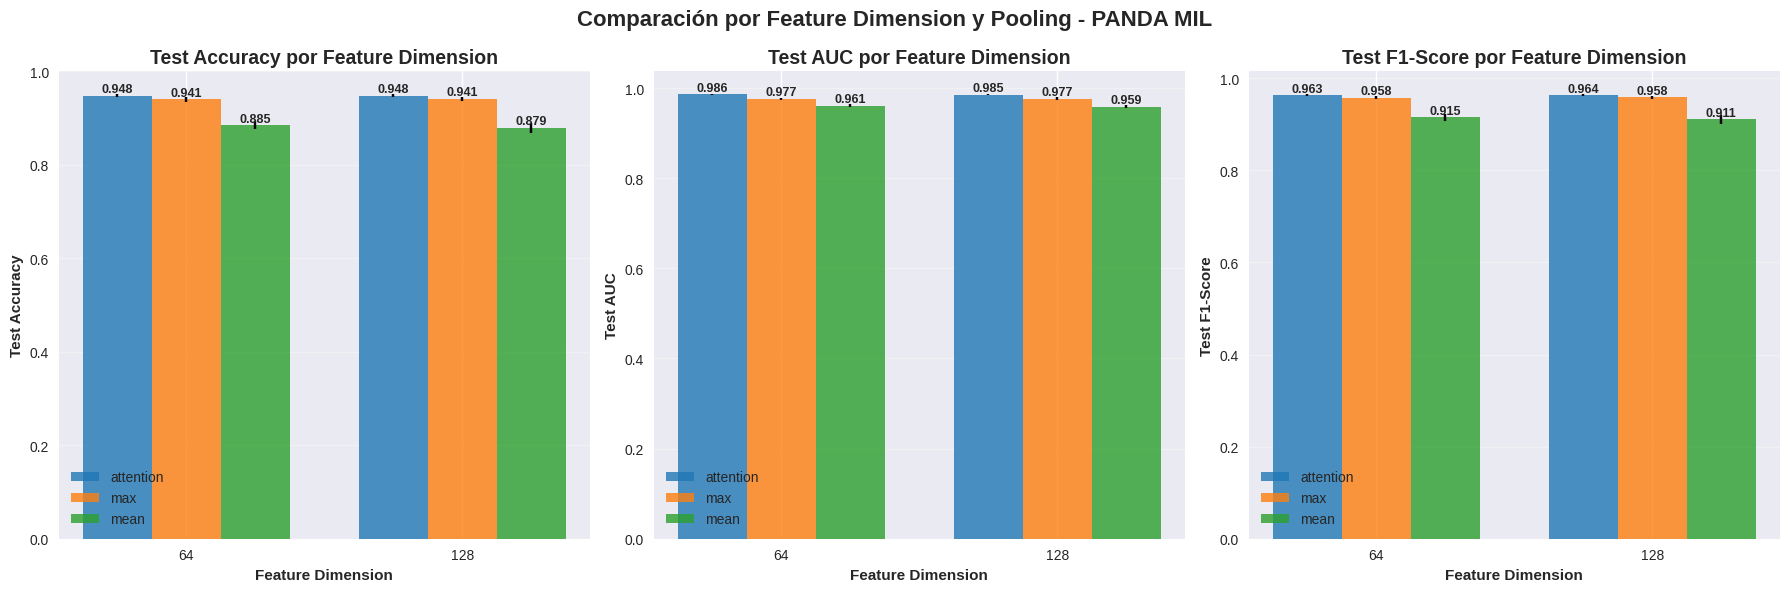

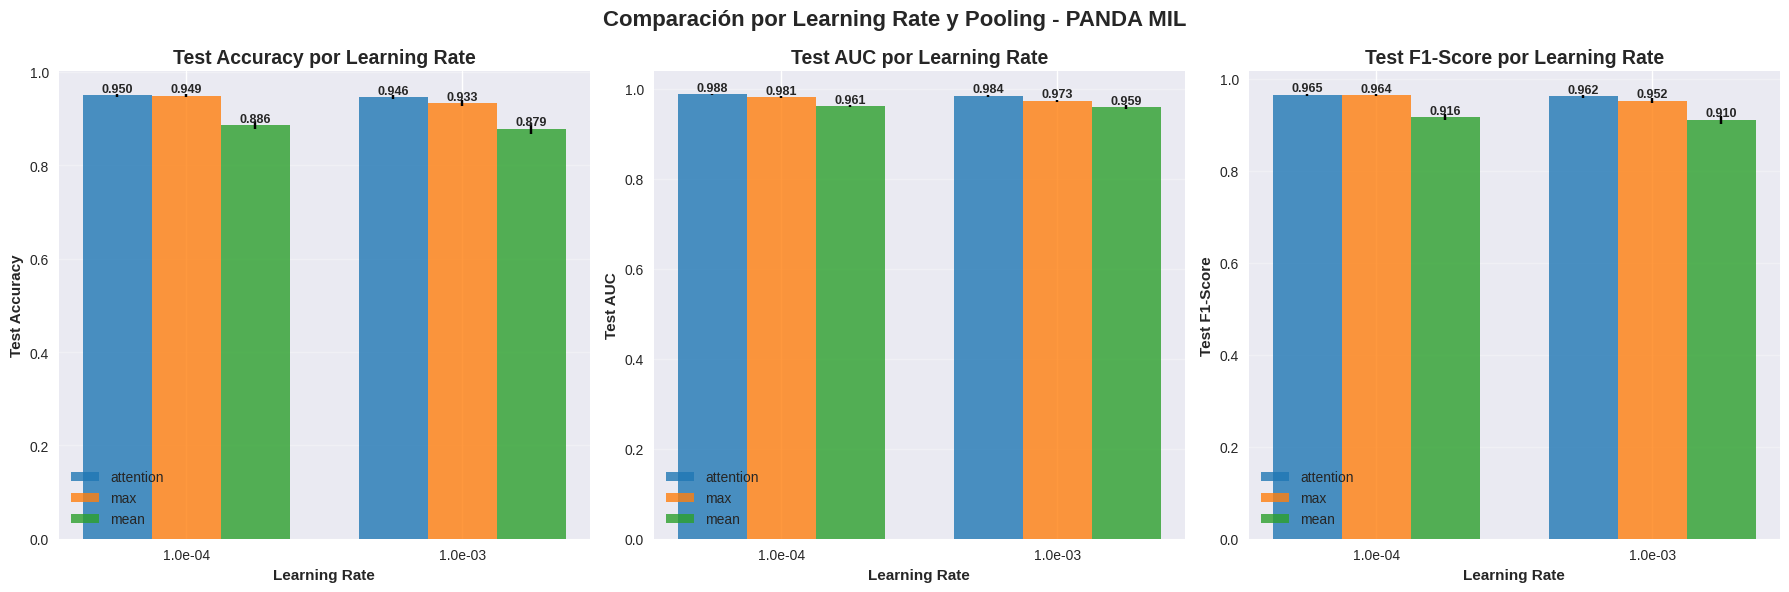

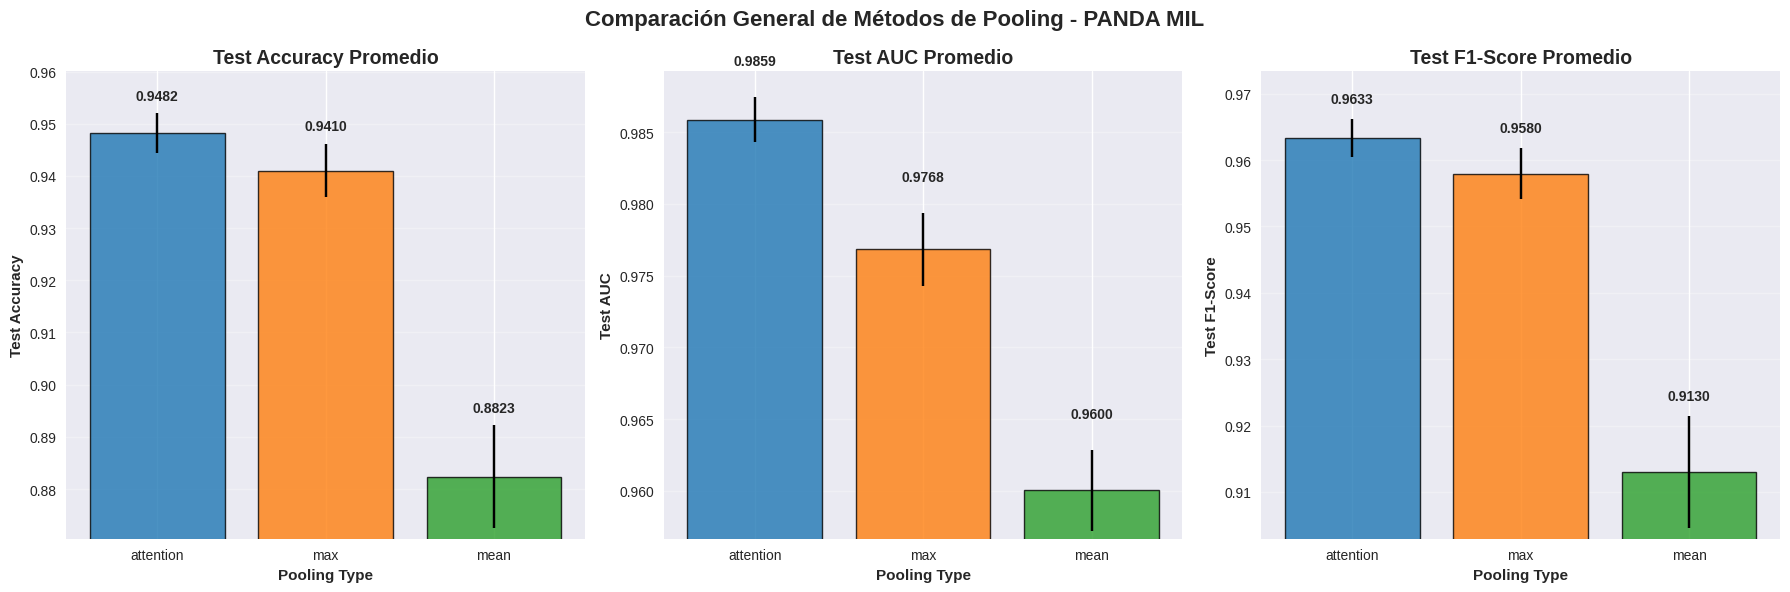

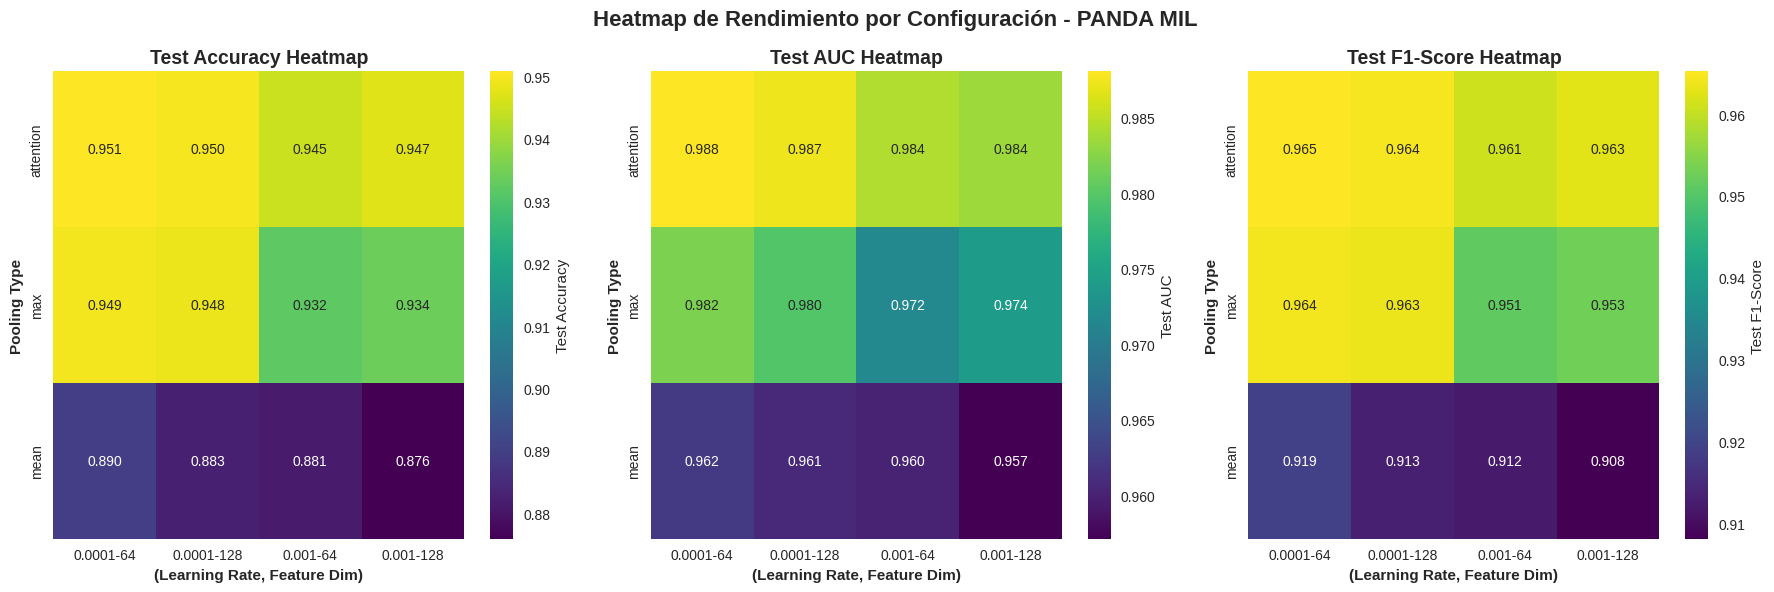


=== RESUMEN ESTADÍSTICO POR POOLING ===
          test_accuracy_mean         test_auc_mean         test_f1_score_mean  \
                        mean     std          mean     std               mean   
pooling                                                                         
attention             0.9482  0.0026        0.9859  0.0022             0.9633   
max                   0.9410  0.0092        0.9768  0.0048             0.9580   
mean                  0.8823  0.0056        0.9600  0.0022             0.9130   

                   
              std  
pooling            
attention  0.0019  
max        0.0068  
mean       0.0045  

=== RESUMEN POR FEATURE DIMENSION Y POOLING ===

--- Feature Dimension: 64 ---
           test_accuracy_mean  test_auc_mean  test_f1_score_mean
pooling                                                         
attention              0.9479         0.9863              0.9631
max                    0.9408         0.9768              0.9578
mean        

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cargar el CSV limpio
df = pd.read_csv('PANDA_clean.csv')

# Configurar estilo
plt.style.use('seaborn-v0_8')

# Métricas a visualizar (usando las medias calculadas)
metrics = ['test_accuracy_mean', 'test_auc_mean', 'test_f1_score_mean']
titles = ['Test Accuracy', 'Test AUC', 'Test F1-Score']
std_metrics = ['test_accuracy_std', 'test_auc_std', 'test_f1_score_std']

# =================== PRIMERA IMAGEN: Comparación por Feature Dimension ===================
fig1, axes1 = plt.subplots(1, 3, figsize=(18, 6))
fig1.suptitle('Comparación por Feature Dimension y Pooling - PANDA MIL', fontsize=16, fontweight='bold')

for i, (metric, title, std_metric) in enumerate(zip(metrics, titles, std_metrics)):
    ax = axes1[i]
    
    # Obtener feature dimensions únicos y ordenados
    feature_dims = sorted(df['feature_dim'].unique())
    pooling_types = sorted(df['pooling'].unique())
    
    # Configurar posiciones para barras agrupadas
    x = np.arange(len(feature_dims))
    width = 0.25
    
    # Crear barras para cada pooling type
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Más colores por si hay más tipos
    for j, pool_type in enumerate(pooling_types):
        means_by_dim = []
        stds_by_dim = []
        
        for feature_dim in feature_dims:
            subset = df[(df['pooling'] == pool_type) & (df['feature_dim'] == feature_dim)]
            if len(subset) > 0:
                means_by_dim.append(subset[metric].mean())
                stds_by_dim.append(subset[std_metric].mean())
            else:
                means_by_dim.append(0)
                stds_by_dim.append(0)
        
        bars = ax.bar(x + j*width, means_by_dim, width, 
                     yerr=stds_by_dim, capsize=3,
                     label=pool_type, alpha=0.8,
                     color=colors[j % len(colors)])
        
        # Añadir valores en las barras
        for k, (bar, mean) in enumerate(zip(bars, means_by_dim)):
            if mean > 0:  # Solo mostrar si hay datos
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                       f'{mean:.3f}', ha='center', va='bottom', 
                       fontsize=9, fontweight='bold')
    
    ax.set_title(f'{title} por Feature Dimension', fontweight='bold', fontsize=14)
    ax.set_xlabel('Feature Dimension', fontweight='bold')
    ax.set_ylabel(title, fontweight='bold')
    ax.set_xticks(x + width * (len(pooling_types) - 1) / 2)
    ax.set_xticklabels(feature_dims)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('panda_pooling_by_featuredim.png', dpi=300, bbox_inches='tight')
plt.show()

# =================== SEGUNDA IMAGEN: Comparación por Learning Rate ===================
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 6))
fig2.suptitle('Comparación por Learning Rate y Pooling - PANDA MIL', fontsize=16, fontweight='bold')

for i, (metric, title, std_metric) in enumerate(zip(metrics, titles, std_metrics)):
    ax = axes2[i]
    
    # Obtener learning rates únicos y ordenados
    learning_rates = sorted(df['learning_rate'].unique())
    pooling_types = sorted(df['pooling'].unique())
    
    # Configurar posiciones para barras agrupadas
    x = np.arange(len(learning_rates))
    width = 0.25
    
    # Crear barras para cada pooling type
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    for j, pool_type in enumerate(pooling_types):
        means_by_lr = []
        stds_by_lr = []
        
        for lr in learning_rates:
            subset = df[(df['pooling'] == pool_type) & (df['learning_rate'] == lr)]
            if len(subset) > 0:
                means_by_lr.append(subset[metric].mean())
                stds_by_lr.append(subset[std_metric].mean())
            else:
                means_by_lr.append(0)
                stds_by_lr.append(0)
        
        bars = ax.bar(x + j*width, means_by_lr, width, 
                     yerr=stds_by_lr, capsize=3,
                     label=pool_type, alpha=0.8,
                     color=colors[j % len(colors)])
        
        # Añadir valores en las barras
        for k, (bar, mean) in enumerate(zip(bars, means_by_lr)):
            if mean > 0:  # Solo mostrar si hay datos
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                       f'{mean:.3f}', ha='center', va='bottom', 
                       fontsize=9, fontweight='bold')
    
    ax.set_title(f'{title} por Learning Rate', fontweight='bold', fontsize=14)
    ax.set_xlabel('Learning Rate', fontweight='bold')
    ax.set_ylabel(title, fontweight='bold')
    ax.set_xticks(x + width * (len(pooling_types) - 1) / 2)
    ax.set_xticklabels([f'{lr:.1e}' for lr in learning_rates])  # Notación científica
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('panda_pooling_by_lr.png', dpi=300, bbox_inches='tight')
plt.show()

# =================== TERCERA IMAGEN: Comparación General ===================
fig3, axes3 = plt.subplots(1, 3, figsize=(18, 6))
fig3.suptitle('Comparación General de Métodos de Pooling - PANDA MIL', fontsize=16, fontweight='bold')

for i, (metric, title, std_metric) in enumerate(zip(metrics, titles, std_metrics)):
    ax = axes3[i]
    
    # Barplot con error bars
    pooling_types = sorted(df['pooling'].unique())
    x_pos = np.arange(len(pooling_types))
    
    means = []
    stds = []
    
    for pool_type in pooling_types:
        subset = df[df['pooling'] == pool_type]
        means.append(subset[metric].mean())
        stds.append(subset[std_metric].mean())
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    bars = ax.bar(x_pos, means, yerr=stds, capsize=5, 
                  color=[colors[j % len(colors)] for j in range(len(pooling_types))], 
                  alpha=0.8, edgecolor='black', linewidth=1)
    
    ax.set_title(f'{title} Promedio', fontweight='bold', fontsize=14)
    ax.set_xlabel('Pooling Type', fontweight='bold')
    ax.set_ylabel(title, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(pooling_types)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Configurar límites del eje Y para resaltar diferencias
    y_min = min(means) - max(stds) * 1.2
    y_max = max(means) + max(stds) * 1.2
    ax.set_ylim(y_min, y_max)
    
    # Añadir valores en las barras
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.002,
                f'{mean:.4f}', ha='center', va='bottom', 
                fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('panda_pooling_general.png', dpi=300, bbox_inches='tight')
plt.show()

# =================== CUARTA IMAGEN: Heatmap de rendimiento ===================
fig4, axes4 = plt.subplots(1, 3, figsize=(18, 6))
fig4.suptitle('Heatmap de Rendimiento por Configuración - PANDA MIL', fontsize=16, fontweight='bold')

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes4[i]
    
    # Crear tabla pivot para heatmap
    pivot_table = df.pivot_table(values=metric, 
                                index='pooling', 
                                columns=['learning_rate', 'feature_dim'], 
                                aggfunc='mean')
    
    # Crear heatmap
    sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='viridis', 
               ax=ax, cbar_kws={'label': title})
    
    ax.set_title(f'{title} Heatmap', fontweight='bold', fontsize=14)
    ax.set_xlabel('(Learning Rate, Feature Dim)', fontweight='bold')
    ax.set_ylabel('Pooling Type', fontweight='bold')

plt.tight_layout()
plt.savefig('panda_pooling_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# =================== RESÚMENES ESTADÍSTICOS ===================
print("\n=== RESUMEN ESTADÍSTICO POR POOLING ===")
summary = df.groupby('pooling')[['test_accuracy_mean', 'test_auc_mean', 'test_f1_score_mean']].agg(['mean', 'std'])
print(summary.round(4))

print("\n=== RESUMEN POR FEATURE DIMENSION Y POOLING ===")
for feature_dim in sorted(df['feature_dim'].unique()):
    print(f"\n--- Feature Dimension: {feature_dim} ---")
    subset = df[df['feature_dim'] == feature_dim]
    if len(subset) > 0:
        dim_summary = subset.groupby('pooling')[['test_accuracy_mean', 'test_auc_mean', 'test_f1_score_mean']].mean()
        print(dim_summary.round(4))

print("\n=== RESUMEN POR LEARNING RATE Y POOLING ===")
for lr in sorted(df['learning_rate'].unique()):
    print(f"\n--- Learning Rate: {lr:.1e} ---")
    subset = df[df['learning_rate'] == lr]
    if len(subset) > 0:
        lr_summary = subset.groupby('pooling')[['test_accuracy_mean', 'test_auc_mean', 'test_f1_score_mean']].mean()
        print(lr_summary.round(4))

# Mejor configuración por métrica
print("\n=== MEJORES CONFIGURACIONES ===")
for metric in metrics:
    if metric in df.columns:
        best_idx = df[metric].idxmax()
        best_config = df.loc[best_idx]
        print(f"\nMejor {metric.replace('test_', '').replace('_mean', '').upper()}:")
        print(f"  Pooling: {best_config['pooling']}")
        print(f"  Feature Dimension: {best_config['feature_dim']}")
        print(f"  Learning Rate: {best_config['learning_rate']:.1e}")
        print(f"  Valor: {best_config[metric]:.4f}")

# Análisis de estabilidad (basado en desviaciones estándar)
print("\n=== ANÁLISIS DE ESTABILIDAD (menor std = más estable) ===")
for std_metric in std_metrics:
    if std_metric in df.columns:
        most_stable_idx = df[std_metric].idxmin()
        most_stable_config = df.loc[most_stable_idx]
        print(f"\nMás estable {std_metric.replace('test_', '').replace('_std', '').upper()}:")
        print(f"  Pooling: {most_stable_config['pooling']}")
        print(f"  Feature Dimension: {most_stable_config['feature_dim']}")
        print(f"  Learning Rate: {most_stable_config['learning_rate']:.1e}")
        print(f"  Std: {most_stable_config[std_metric]:.4f}")

print(f"\n=== IMÁGENES GENERADAS ===")
print("1. panda_pooling_by_featuredim.png - Comparación por feature dimension")
print("2. panda_pooling_by_lr.png - Comparación por learning rate")
print("3. panda_pooling_general.png - Comparación general promedio")
print("4. panda_pooling_heatmap.png - Heatmap de rendimiento por configuración")